In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout, BatchNormalization, Add, Activation, Input, GlobalAveragePooling2D
from keras.layers.merge import concatenate
from keras.activations import relu, softmax
from keras.regularizers import l2
from keras import optimizers
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
#x_trainN1 = (x_train - 127.5) / 255.0
x_trainN1 = x_train - x_train.mean(axis=0)
#x_trainN1 = x_trainN1 / np.sqrt((x_trainN1 ** 2).sum(axis=1))[:,None]
x_trainN1 = x_trainN1 / np.std(x_trainN1)
print(x_trainN1.mean(), np.std(x_trainN1))
y_trainN1  = keras.utils.to_categorical(y_train, num_classes=10)

-9.059419880941278e-18 0.9999999999999999


In [0]:
x_trainN1, x_validN1, y_trainN1, y_validN1 = train_test_split(x_trainN1, y_trainN1, test_size=0.1, shuffle=True, random_state=42)

In [0]:
def plot_history(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Valid'], loc='upper right')
  plt.show()

In [0]:
models = []
for i in range(5):
  model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/ResNet/ResNet20_mod_0_{}.hdf5'.format(i))
  for layer in model.layers:
    layer.trainable = False
    layer.name = layer.name + '-' + str(i)
  model.name="ResNet-{}".format(i)
  models.append(model)
  


In [0]:
def stacked_model(models):
	# define multi-headed input
	ensemble_visible = [model.input for model in models]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in models]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(100, activation='relu')(merge)
	output = Dense(10, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	return model

In [0]:
ensemble.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13-0 (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_14-1 (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_15-2 (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_16-3 (InputLayer)         (None, 32, 32, 3)    0                                            
____________________________________________________________________________________________

In [0]:
def lfScheduleF(epoch, lr):
  if epoch > 7:
      return 0.01
  return 0.1

lrscheduler = LearningRateScheduler(lfScheduleF, verbose=0)

Epoch 1/10
5000/5000 [==============================] - 83s 17ms/step - loss: 1.4110 - accuracy: 0.8500
Epoch 2/10
5000/5000 [==============================] - 80s 16ms/step - loss: 0.9435 - accuracy: 0.9320
Epoch 3/10
5000/5000 [==============================] - 80s 16ms/step - loss: 0.9304 - accuracy: 0.9318
Epoch 4/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.9265 - accuracy: 0.9346
Epoch 5/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.9235 - accuracy: 0.9320
Epoch 6/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.9197 - accuracy: 0.9310
Epoch 7/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.9154 - accuracy: 0.9352
Epoch 8/10
5000/5000 [==============================] - 85s 17ms/step - loss: 0.9251 - accuracy: 0.9340
Epoch 9/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.9610 - accuracy: 0.9222
Epoch 10/10
5000/5000 [==============================] - 81s 16m

KeyError: ignored

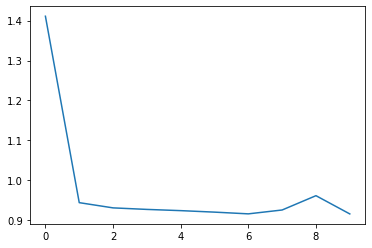

In [14]:
ensemble = stacked_model(models)

opt = optimizers.SGD(learning_rate=0.1, momentum=0.9)
ensemble.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


X = [x_validN1 for _ in range(5)]

history = ensemble.fit(X, y_validN1, batch_size=128, epochs=10, verbose=1, callbacks=[lrscheduler])
plot_history(history)

In [10]:
#x_testN1 = (x_test - 127.5) / 255.0
x_testN1 = (x_test - x_test.mean()) / np.std(x_test)
print(x_testN1.mean(), np.std(x_testN1))
#x_testN1 = x_testN1 / np.sqrt((x_train ** 2).sum(axis=1))[:,None]
y_testN1  = keras.utils.to_categorical(y_test, num_classes=10)

-8.459899447643693e-17 1.000000000000001


In [15]:
X = [x_testN1 for _ in range(5)]
ensemble.evaluate(X, y_testN1, verbose=1)

10000/10000 [==============================] - 194s 19ms/step


[0.9928805055618286, 0.9168999791145325]

In [0]:
def get_confusion_matrix(x, y, model, no_labels=10):

    if y.shape[1] != 1: # 0-9 encoding
        y = np.argmax(y, axis=1)
    else:
        y = y.flatten() # one-hot encoding
    confusion_matrix = np.zeros((no_labels, no_labels)).astype(int)
    pred = np.argmax(model.predict(x), axis=1)
    for i in range(pred.shape[0]):
        confusion_matrix[pred[i], y[i]] += 1
    return confusion_matrix

In [19]:
get_confusion_matrix(X, y_testN1, ensemble)

array([[909,   3,  15,   4,   1,   2,   1,   4,  19,   6],
       [  5, 974,   0,   2,   1,   0,   0,   0,   7,  29],
       [ 40,   1, 911,  42,  21,  27,  20,  15,   5,   4],
       [  7,   1,  18, 815,  18,  87,  15,   8,   3,   3],
       [  5,   1,  21,  26, 925,  19,   5,  25,   2,   0],
       [  0,   0,   7,  52,   7, 841,   1,   6,   1,   0],
       [  5,   0,  24,  37,  17,  12, 955,   3,   3,   2],
       [  3,   0,   2,  14,   9,  12,   1, 939,   1,   0],
       [ 20,   2,   2,   5,   1,   0,   1,   0, 952,   8],
       [  6,  18,   0,   3,   0,   0,   1,   0,   7, 948]])